In [16]:
from glob import glob

scores = {"intersec": {}, "algnWoutOffs": {}}

#Iterate over simulation results
for m in scores.keys():
    for f in glob(f"../simulations/scores_mes{m}_s20620220951_n100_l10008_m*.txt"):
        #Parse mutation rate from file name
        mRate = float(f.split("_m")[2].split("_i")[0])
        #Initialize a score list for each mutation rate
        scores[m][mRate] = []

        for l in open(f, 'r'):
            scores[m][mRate].append(int(l))

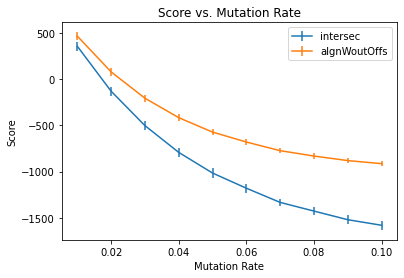

In [17]:
from matplotlib import pyplot as plt
from numpy import mean, std

rateRange = sorted(scores["algnWoutOffs"].keys())

for m in scores.keys():
    plt.errorbar(rateRange, [mean(scores[m][r]) for r in rateRange], yerr=[std(scores[m][r]) for r in rateRange], \
                label=m)
    
plt.title("Score vs. Mutation Rate")
plt.xlabel("Mutation Rate")
plt.ylabel("Score")
plt.legend()
plt.show()

# Homology Scores

In [1]:
#Mapping between a nucleotide character and its bitwise representation
NT_IN_BITS = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

#This function calculates the hash of a bitwise k-mer representation. The function is influenced by the code of "The minimizer Jaccard estimator is 
#biased and inconsistent." from Belbasi et al. (function "minimap2_hash(seed,v,mask)" in file "minimap2_hash_uncompiled.py").
def getHash(kmer, mask):
    u = kmer & mask
    u = ((~u) + (u << 21)) & mask # u = (u<<21)-(u+1) = 77594587*u-1
    u = u ^ (u >> 24)
    u = ((u + (u << 3)) + (u << 8)) & mask # u *= 265
    u = u ^ (u >> 14)
    u = ((u + (u << 2)) + (u << 4)) & mask # u *= 21
    u = u ^ (u >> 28)
    u = (u + (u << 31)) & mask # u *= 2147483649

    return u

#This function calculates the sketch of a sequence. It is influenced by the code of "The minimizer Jaccard estimator is biased and inconsistent."
#from Belbasi et al. (function "hash_sequence(seq,kmerSize,hashFunc,canonical=False)" in file "jaccard_correction_test.py").
def calcSketch(seq, k, thres):
    sketch = []

    #Calculate mask
    mask = (4 ** k) - 1

    #Iterate of all k-mers in sequence
    for i in range(len(seq) - k + 1):
        kmerBits = 0

        #Get bit representation of k-mer
        for c in seq[i:i+k]:
            kmerBits = (kmerBits << 2) + NT_IN_BITS[c]

        #Calculate hash
        kmerHash = getHash(kmerBits, mask)

        #Add hash to sketch if it is small enough
        if kmerHash <= thres:
            sketch.append((i, kmerHash))

    return sketch

In [145]:
from glob import glob
from math import floor

#K-mer length
K = 9

def getTextSketches(filesPath):
    #Dictionary to store sketches of all texts
    textSketches = {}
    
    #Calculate sketches of sequences
    for f in glob(filesPath):
        #Get mutation rate
        mRate = float(f.split("_m")[1].split("_i")[0])
        #Initialize new list
        textSketches[mRate] = []
        #Calculate hash threshold
        thres = floor(((4 ** K) - 1) * 0.1)
    
        for l in open(f, 'r'):
            textSketches[mRate].append(calcSketch(l.strip().split(' ')[1], K, thres))
        
    return textSketches
        
textSketches = getTextSketches("../simulations/searchPairs_gn100_rn400_gl1000_rl500_o3_m0*")

In [132]:
##Load found t-homologies##

#A dictionary for all scores
scores = {}
#A dictionary to store the number ob found t-homologies per pair
homsPerPair = {}
#A dictionary to store the percentage of coverage of real homologies by t-homologies
percCovs = {}
#A dictionary to store start end stop positions of all t-homologies
coords = {}

for f in glob("../simulations/homologies_gn100_rn400_gl1000_rl500_o3_m0*"):
    #Get mutation rate
    mRate = float(f.split("_m")[1].split("_i")[0])
    lastPairID = 1
    nbHoms = 0
    
    #Initialize new lists
    for d in scores, homsPerPair, percCovs, coords:
        d[mRate] = []
    
    for l in open(f, 'r'):
        l.strip()
        
        if l.startswith("Pair"):
            pairID = int(l.split(' ')[1])
            coords[mRate].append([])
            continue
            
        if l.startswith('['):
            #Get score
            scores[mRate].append(int(l.split(' ')[1]))
            #Get start position in sequence
            start = textSketches[mRate][pairID - 1][int(l.split('[')[1].split(',')[0])][0]
            #Get end position in sequence
            end = textSketches[mRate][pairID - 1][int(l.split(',')[1].split(']')[0])][0]
            #Save start and end coordinates
            coords[mRate][-1].append((start, end))
            #Add sequence coverage
            percCovs[mRate].append((end - start) / 5000.)
            
            #Check if we are dealing with a new pair
            if lastPairID != pairID:
                homsPerPair[mRate].append(nbHoms)
                nbHoms = 0
                lastPairID = pairID
                
            #Count homologies for this pair
            nbHoms += 1
    
    homsPerPair[mRate].append(nbHoms)
    
    #Testing
    #print("len(coords[mRate])", len(coords[mRate]))

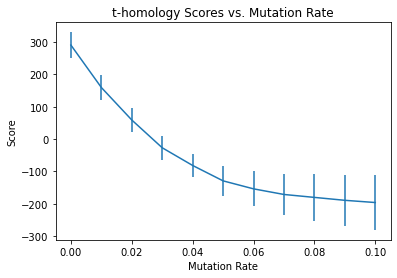

In [48]:
from matplotlib import pyplot as plt
from numpy import mean, std

rates = sorted(scores.keys())
plt.errorbar(rates, [mean(scores[r]) for r in rates], yerr=[std(scores[r]) for r in rates])    
plt.title("t-homology Scores vs. Mutation Rate")
plt.xlabel("Mutation Rate")
plt.ylabel("Score")
plt.show()

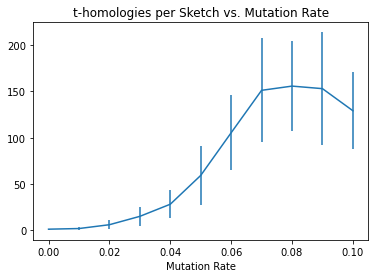

In [49]:
rates = sorted(homsPerPair.keys())
plt.errorbar(rates, [mean(homsPerPair[r]) for r in rates], yerr=[std(homsPerPair[r]) for r in rates])    
plt.title("t-homologies per Sketch vs. Mutation Rate")
plt.xlabel("Mutation Rate")
plt.show()

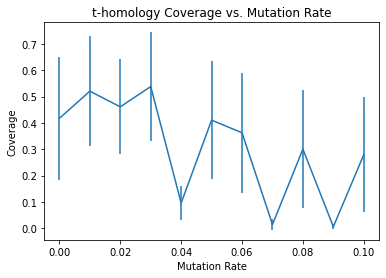

In [133]:
rates = sorted(percCovs.keys())
plt.errorbar(rates, [mean(percCovs[r]) for r in rates], yerr=[std(percCovs[r]) for r in rates])    
plt.title("t-homology Coverage vs. Mutation Rate")
plt.xlabel("Mutation Rate")
plt.ylabel("Coverage")
plt.show()

## Find Threshold Score to Find All Homologies

In [134]:
#Map scores to coordinates
results = {}

for m in scores.keys():
    results[m] = []
    i = 0
    
    for p in coords[m]:
        results[m].append([])
        
        for c in p:
            results[m][-1].append((scores[m][i], c[0], c[1]))
            i += 1

In [151]:
#Load pattern sketches
def loadPatternSketches(filesPath):
    patternSketches = {}

    for f in glob(filesPath):
        #Get mutation rate
        mRate = float(f.split("_m")[1].split("_i")[0])
        #Initialize new list
        patternSketches[mRate] = []
        #Calculate hash threshold
        thres = floor(((4 ** K) - 1) * 0.1)
    
        for l in open(f, 'r'):
            patternSketches[mRate].append(calcSketch(l.strip().split(' ')[0], K, thres))
        
    return patternSketches

patternSketches = loadPatternSketches("../simulations/searchPairs_gn100_rn400_gl1000_rl500_o3_m0*")

In [153]:
#Calculate initial homology intervals
def calcHomIntervals(textSketches, patternSketches, iniHomStart, iniHomEnd, homSteps):
    homInts = {}

    for m in textSketches.keys():
        homInts[m] = []
    
        for i in range(len(textSketches[m])):
            patternHashes = [p[1] for p in patternSketches[m][i]]
            homInts[m].append([])
            nextHomStart = iniHomStart
            nextHomEnd = iniHomEnd
        
            #Testing
            #first = True
        
            for h in textSketches[m][i]:
                if nextHomStart < nextHomEnd:
                    if h[1] in patternHashes and h[0] >= nextHomStart and h[0] <= nextHomEnd:
                    
                        #Testing
                        #if m == 0.0 and i == 0 and first:
                        #    print(h[1])
                        #    print("At position", h[0])
                        #    first = False
                        
                        homInts[m][i].append([h[0], h[0]])
                        nextHomStart += homSteps
                else:
                    if h[1] in patternHashes and h[0] <= nextHomEnd:
                        homInts[m][i][-1][1] = h[0]
                
                    if h[0] > nextHomEnd:
                        nextHomEnd += homSteps
                    
    return homInts    

homInts = calcHomIntervals(textSketches, patternSketches, 500, 1500, 1500)

In [126]:
#Testing
firstPairPattern = [p[1] for p in patternSketches[0][0]]
patternFromScript = [6819, 4825, 2786, 17024, 11466, 9845, 14117, 16318, 15893, 26111, 15483, 23409, 22874, 22613, 16477, 14592, 10367, 5826, 22632, 11640, 24216, 15968, 1870, 13045, 22837, 3813, 15651, 1424, 16826, 21844, 22333, 4823, 16707, 19329, 25866, 20378, 8250, 17955, 19157, 12068, 7770, 15692, 3559, 25420, 22007, 8527, 202, 12274, 22915, 4289, 16148, 21313, 7970, 1126, 9397, 13802, 18349, 23990, 22671, 7396, 14256, 16772, 23997, 2904, 16824, 13492, 9498, 13999, 3964, 16617, 15133, 16170, 20002, 2809, 2582, 10391, 25520, 8973, 10031, 19638, 20844, 14615, 10164, 3754]

if firstPairPattern == patternFromScript:
    print("Patterns are equal")
else:
    print("Patterns are NOT equal")
    
patternFromScript.index(20729)

Patterns are equal


ValueError: 20729 is not in list

In [148]:
from math import inf

def findMinScores(results, homInts):
    #Find threshold score
    minScores = {}

    for m in results.keys():
        minScore = inf
    
        for i in range(len(results[m])):
            pairResults = sorted(results[m][i], key=lambda r: r[0], reverse=True)
            intervals = list(homInts[m][i])
        
            while pairResults and intervals:
                res = pairResults.pop(0)
                newIntervals = []
            
                for intv in intervals:
                    if res[1] >= intv[0] and res[1] <= intv[1]:
                        if res[1] - intv[0] > 0:
                            newIntervals.append([intv[0], res[1] - 1])
                    if res[2] >= intv[0] and res[2] < intv[1]:
                        newIntervals.append([res[2] + 1, intv[1]])
                    if res[1] > intv[1]:
                        newIntervals.append(intv)
                    if res[2] < intv[0]:
                        newIntervals.append(intv)
                      
                #Testing
                #print("res:", res)
                #print("intervals:", intervals)
                #print("newIntervals:", newIntervals)
            
                intervals = newIntervals
            
                if minScore > res[0]:
                    minScore = res[0]
                
        minScores[m] = minScore
        
    return minScores

In [149]:
minScores = findMinScores(results, homInts)

minScores

{0.06: -123,
 0.01: -95,
 0.09: -387,
 0.07: -390,
 0.05: -122,
 0.0: 158,
 0.08: -142,
 0.1: -162,
 0.03: -56,
 0.04: -352,
 0.02: -276}

In [136]:
for m in results.keys():
    print(m, min([r[0] for p in results[m] for r in p]))

0.06 -345
0.01 -312
0.09 -387
0.07 -390
0.05 -317
0.0 -139
0.08 -416
0.1 -450
0.03 -141
0.04 -362
0.02 -361


In [144]:
#Load non-unit score results

def loadHomologies(filesPath, textSketches):
    res = {}

    for f in glob(filesPath):
        #Get mutation rate
        mRate = float(f.split("_m")[1].split("_i")[0])
        lastPairID = 1
    
        res[mRate] = []
    
        for l in open(f, 'r'):
            l.strip()
        
            if l.startswith("Pair"):
                pairID = int(l.split(' ')[1])
                res[mRate].append([])
                continue
            
            if l.startswith('['):
                #Get start position in sequence
                start = textSketches[mRate][pairID - 1][int(l.split('[')[1].split(',')[0])][0]
                #Get end position in sequence
                end = textSketches[mRate][pairID - 1][int(l.split(',')[1].split(']')[0])][0]
                #Save score, start and end coordinates
                res[mRate][-1].append((int(l.split(' ')[1]), start, end))
            
    return res

nonUnitRes = loadHomologies("../simulations/homologies_gn100_rn400_gl1000_rl500_o3_m0*_c1_u3.txt", textSketches)
print(nonUnitRes[0])

[[(24, 511, 4467), (105, 2011, 4467), (168, 3511, 4467), (87, 511, 2967), (168, 2011, 2967), (168, 511, 1467)], [(87, 522, 4477), (150, 2022, 4477), (180, 3522, 4477), (117, 522, 2977), (180, 2022, 2977), (180, 522, 1477)], [(128, 511, 4490), (161, 2011, 4490), (208, 3511, 4490), (175, 511, 2990), (208, 2011, 2990), (208, 511, 1490)], [(57, 204, 4490), (104, 502, 4490), (141, 2002, 4490), (214, 3502, 4490), (130, 204, 2990), (177, 502, 2990), (214, 2002, 2990), (167, 204, 1490), (214, 502, 1490)], [(173, 502, 4463), (207, 2002, 4463), (220, 3502, 4463), (186, 502, 2963), (220, 2002, 2963), (220, 502, 1463)], [(87, 506, 4583), (133, 2006, 4583), (158, 3506, 4583), (131, 506, 4491), (177, 2006, 4491), (202, 3506, 4491), (156, 506, 2991), (202, 2006, 2991), (202, 506, 1491)], [(58, 500, 4741), (73, 2000, 4741), (139, 3500, 4741), (129, 500, 4485), (144, 2000, 4485), (210, 3500, 4485), (195, 500, 2985), (210, 2000, 2985), (210, 500, 1485)], [(-11, 500, 4490), (72, 2000, 4490), (158, 3500, 

In [131]:
nonUnitMinScores = findMinScores(nonUnitRes, homInts)

nonUnitMinScores

{0.06: -360,
 0.05: -382,
 0.09: -387,
 0.08: -381,
 0.01: -95,
 0.1: -373,
 0.03: -315,
 0.07: -390,
 0.0: 158,
 0.02: -276,
 0.04: -352}

In [102]:
for m in nonUnitRes.keys():
    print(m, min([r[0] for p in nonUnitRes[m] for r in p]))

0.06 -360
0.05 -382
0.09 -387
0.08 -381
0.01 -312
0.1 -373
0.03 -382
0.07 -390
0.0 -139
0.02 -361
0.04 -362


Mutation rate: 0.0


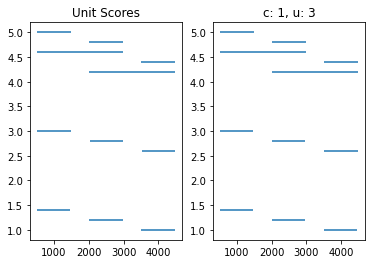

Mutation rate: 0.01


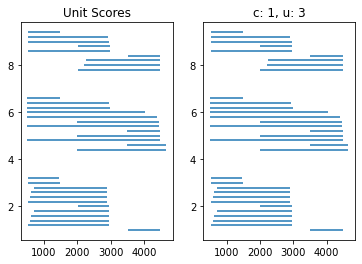

Mutation rate: 0.02


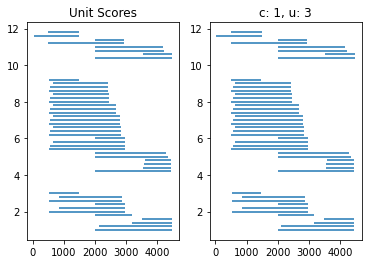

Mutation rate: 0.03


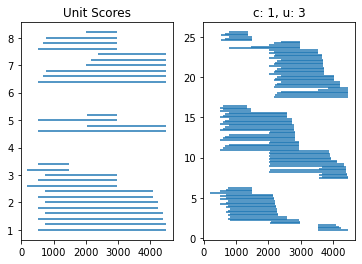

Mutation rate: 0.04


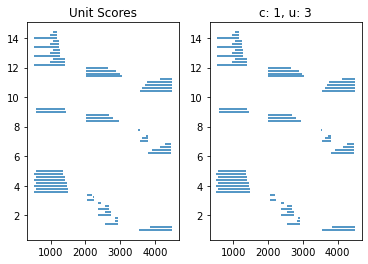

Mutation rate: 0.05


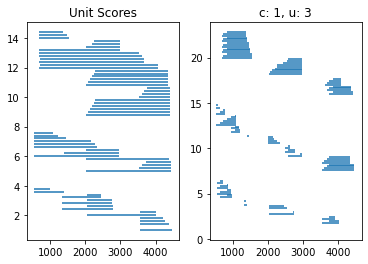

Mutation rate: 0.06


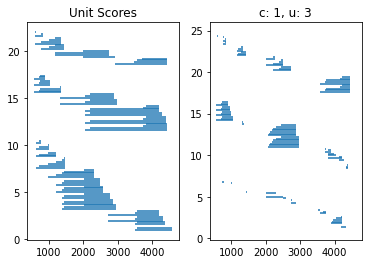

Mutation rate: 0.07


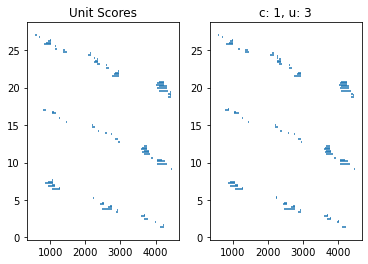

Mutation rate: 0.08


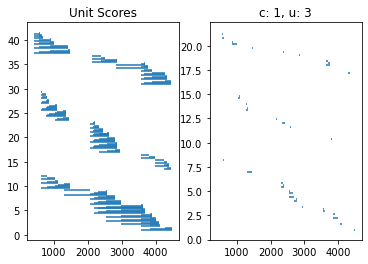

Mutation rate: 0.09


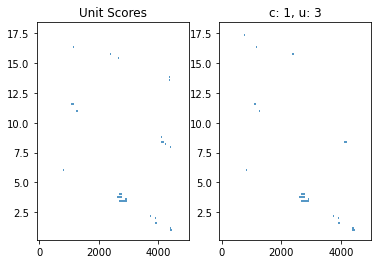

Mutation rate: 0.1


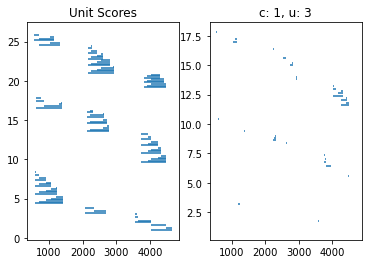

In [137]:
mRates = sorted(results.keys())
allRes = [results, nonUnitRes]
allMinScores = [minScores, nonUnitMinScores]
titles = ["Unit Scores", "c: 1, u: 3"]

for m in mRates:
    print("Mutation rate:", m)
    
    fig, axes = plt.subplots(1, 2)
          
    for i in range(len(allRes)):
        maxY = 1.
        padding = 0.2
          
        for ps in allRes[i][m][:3]:
            toPlot = [p for p in ps if p[0] >= allMinScores[i][m]]
            axes[i].hlines([maxY + j * padding for j in range(len(toPlot))], [t[1] for t in toPlot], [t[2] for t \
                                                                                                      in toPlot])
            maxY += 1. + padding * len(toPlot)
          
        axes[i].set_title(titles[i])
        
    plt.show()

# New Simulations - Single Pattern Occurrence in Text

In [152]:
#Get sketches of new texts
snglPttnTextSketches = getTextSketches("../simulations/searchPairs_gn100_rn200_gl1000_rl1000_o1_m0*")
#Load new results
snglPttnRes = loadHomologies("../simulations/homologies_gn100_rn200_gl1000_rl1000_o1_m0*", snglPttnTextSketches)
#Calculate pattern sketches for single pattern text pairs
snglPttnPatternSketches = loadPatternSketches("../simulations/searchPairs_gn100_rn200_gl1000_rl1000_o1_m0*")
#Calculate homology intervals for single pattern texts
snglPttnHomInts = calcHomIntervals(snglPttnTextSketches, snglPttnPatternSketches, 1000, 2000, 2500)
#Calculate thresholds
snglPttnMinScores = findMinScores(snglPttnRes, snglPttnHomInts)

print("Threshold scores for single pattern texts:")
print(snglPttnMinScores)
print("Min scores of single pattern texts:")

for m in snglPttnRes.keys():
    print(m, min([r[0] for p in snglPttnRes[m] for r in p]))

2259
At position 1009
Threshold scores for single pattern texts:
{0.1: -119, 0.0: 148, 0.02: -5, 0.07: -119, 0.09: -125, 0.04: -108, 0.08: -119, 0.03: -46, 0.06: -116, 0.01: 53, 0.05: -112}
Min scores of single pattern texts:
0.1 -119
0.0 43
0.02 -108
0.07 -119
0.09 -125
0.04 -111
0.08 -121
0.03 -111
0.06 -118
0.01 -68
0.05 -118


Mutation rate: 0.0


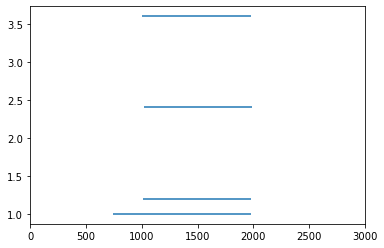

Mutation rate: 0.01


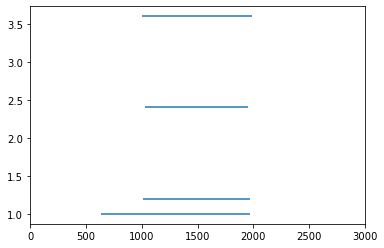

Mutation rate: 0.02


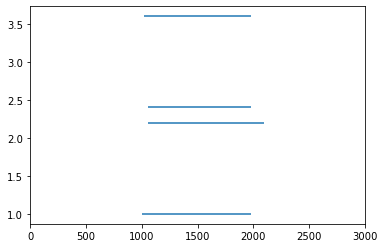

Mutation rate: 0.03


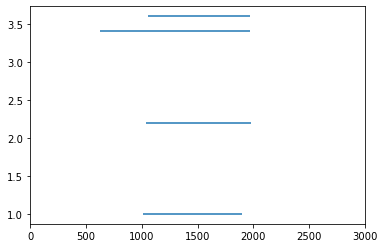

Mutation rate: 0.04


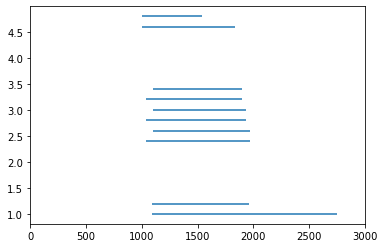

Mutation rate: 0.05


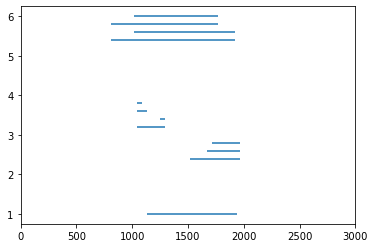

Mutation rate: 0.06


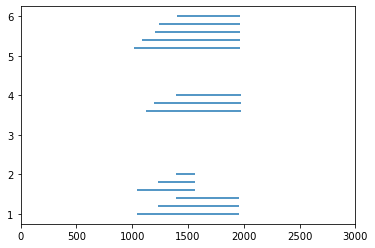

Mutation rate: 0.07


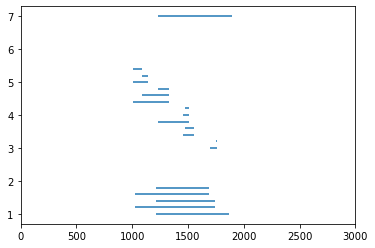

Mutation rate: 0.08


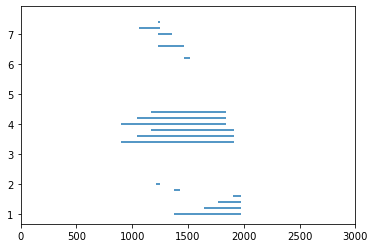

Mutation rate: 0.09


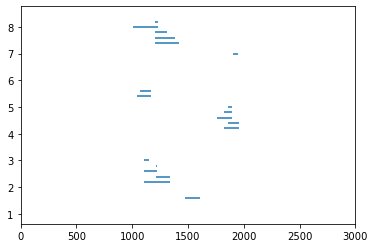

Mutation rate: 0.1


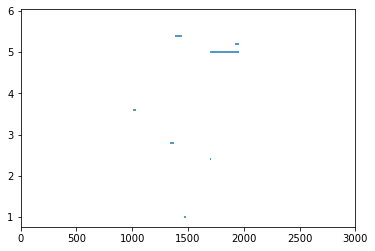

In [156]:
mRates = sorted(snglPttnRes.keys())

for m in mRates:
    print("Mutation rate:", m)
    
    maxY = 1.
    padding = 0.2
          
    for ps in snglPttnRes[m][:3]:
        toPlot = [p for p in ps if p[0] >= snglPttnMinScores[m]]
        plt.hlines([maxY + j * padding for j in range(len(toPlot))], [t[1] for t in toPlot], [t[2] for t \
                                                                                                      in toPlot])
        maxY += 1. + padding * len(toPlot)
        plt.xlim([0, 3000])
        
    plt.show()

# Testing

In [142]:
len("ACTGCATAGCCCCGGGCCTAACTTATGACCGAACCGGGTTGCAGATGAATAATAGCTCACCTCCGAAAAGCTATAGACCATTTACGCAAGCTACACGGGGCAGTTGAAGGCGCTCGTTCGACCTTTAAAACGTCTGCGAAAGTCTGGCACCCTGAACTGGTCCCAGCAACTTCTTGAAGATTGAGCGCTCAAGATTAGCTGGACGATGTAGACGACAAACGTGGAACACGAAATCGGTTCCCGAGTCCCCCCTTGGGAAGCTAGTCTGACCGAGCAGCCGGACCCTTGTTTGCCCTATGGATTTGGCTCGCCCAGAGTTAGCTACGAACCTTTCCGCGATGGCATTTGCCGTCTGCGACGCTCTAATAACTTCTAAAGTGCCTCATGCTATTGTCCTACCGAAGTGGCAGTGTCTGTCGTAATATATTCCGATCTTAGTGTCCCTCCACTCGACGCCACTAAGCACTGGAGTTCGAGAGAGCCTGACGCGCGGTCAGCAGAGCACCTGCCGAAAGTACCCTACAAGCTGGCGCTTCTTCACAATTCTGAGGTGGGTTACCCCTCCCGTCCTTTAATATCTCCGAGTGTCACGAGCATTGCGGCATAATACAGAGTTAGTTCTTACTTGAGACAATCACCGATTACAGAGATGGAGTGCTCCGATTTGGGTACTGTTGCGTTCACAAGAACTGGAAGCGATAGTGACGGCCTCTGCAGTTTTTCGTGACCGGGGCTTCAATTGCCAAGCTCGATATAAGTCGACGGTCTTCCTCTCCTGACATCATCGTAGGAAGATCAGTCGTGACTTGAGTCTCCCCTATAGATTACTCTGTACTTCACGTGACTAGGTCGCACTGGATTATACAGCTGTAAACCTACGGAACGTTTGACCGATGACAACCAATTGCGGATACAGTGATTCTATCTCCACCGCGAGATGGCCAGATCTGACCATTATACCGCGTAATTACACTCACATGCACTGCGTTGGAACCGACTAATCGAGTCCAACCCGACGGTGTTTCAGACTCTCGGCTCACAGCCACAAGGGTTTACAGCTATAAAGCAAGCAAAGTCATTATGCCAAGCTGGTATTATGGCGTGACCATACGTTGTTGGAATGGGGCGGTCGCCACCGTAGCGACTGTGGTTATTTGAAGCCAGGAACCATAGGCGCCAAATTAGAAAAAGGTTTTGCGTTTATTCCAAGGTAGATCCGCGGCCCCCCTTGTATACAAGCAATGTACTTAAGTAAGGTGCAAGTAGGAAGTTTGGTAAAGGCTGTTCGGCGTCCGGTTATTACCACATGACCGGTGACATGCCTATCAACGGACTTACTCTAGACATGTGACCGCTAGTCCGTCGCAATTCTCCAGATTCCGGCTAAAACATTCCAGTTACCTCGTCGGCAATGAGTCGATCTAAGACCTAAGTCACGTTTGTGCTAAGGTTAGTCTGAGTGCCCGGCCACGGGTGATCTATGGGTCACACCGGTCCCCTACCCGGCATGGAGAGGATCGGGATGCGCCCGTAAGCGAAGTCTACTTTGGGAAGTCCCGAACAAGAAAGCCGCTTTCTTACTGCTTCGTACAGGACCGCAACGCAGGTCAACGTTCAGGTAAGACGTTCTTGTTGCCTTTTGGGATACAAGAACACATTTGTTACTTCGCCGGATACTCTCATTAGAAACTGCCAGGGAGACACGATTTTTGTCACGTCACAATAGGCATCTCCGAGAACGTAGCGTTTCTTAGACACTACCTCGCTCAGGGTAGACTGGTTCCATTTAGCTTATATCTCAGGACTTGGAACGCCGTTACTAGGATGGTTGGCCGCAGGGGAACTGTTTATGTTCCCGCAATTTTGATGCTGTCAAAATGACGGTTTTATTGTCGACCTTTACCATGGTTCGCTAGAAACCCCGTATGTGTAGAGCAAAAAGTGAAAACCTTTTTAATACCACCACGAAAAGATGACGTTACCGGAGAATCAAACCATGCTCGTATTTATTGCAAGTGGAAGGATAATTAAATATTATCTCGGCAGCTCTACTTTCCGGCGGTTGCTAAGGGGTCCGCAGACATCAGTCTAGATTTTATAGACCGGATATCTATCCGAACTAGAGGCGACGTAGAGCGGCATTGACTAGACTCCGCCGACTTACCCTGGACTCGATTGCGTGTACGACATATCAAACTGCCGCCAGGCGGAGAATGACATCAACGACAGCGTGTGTTCGTGAAAGCTAGTTCCGGTGATATTACAACCGGGTAGCACGAAGGCCCCATGTGGCTCTCGTTGCTTATCGGCTAGCGCTATCATGTACTAGACGTCCGTCCAAGTTTCGGACCATGGGAGCTTTCATGGAAAAGCCGTGGGCTGCAACAGCCACTAGAGTTCGCGGCTCTTCGATATCAGTACTCATGGCCCTACCTAACCAACGGTTTATAGACAGACGGACAGTTGGTAAATATATTCCTCAGGGAGTTACGTTCGGTGACAATAGGCGTGATCCCTCCGGGCTGGGAGCCAAATTAGCCGCCTATTCGGGCGTACTGACCATTGATACGATCTCTTGGTTGCTCGACTAATTACCCGTAGTTATGGTTACTCTAATTAGATTGAACGATTCGGCAATCAAGCCTTCGAGCAAGAGGTGGCAGGATGGAGCCGTAAGCGAGCATCCCTACGAGCCCATTAATACTGTTTAGTCGGAGCAGGTGGTATACCGACGGGACAACTGCATCTAAGATTATTGCAGGAACTATGAGTCGGGGTTAGTTCGTCTCTGATAGGAAGGATCAGGTTAAAAGTGTGACTTCCAGCCAGGTTATGTAATAGGGATGCTAGCATTAGACGCAGGCCTGCCTAGCCCCTCTAGCCGCCCTCCCAAAGTTCCATTGTATGCTGCATCAAGGACAAGGCAACTCTTTAACATGTTAGCCTCACGAATGTTAGAGTCGTCGTTTGCAAACAGAGGGCTCGAGCGTCTAGGAGCCA")

3000

In [127]:
f = open("../simulations/searchPairs_gn100_rn400_gl1000_rl500_o3_m0_i0_d0.txt", 'r')
textSeq = f.readline().split(' ')[1].strip()

print("K:", K)

thres = floor(((4 ** K) - 1) * 0.1)
print(calcSketch(textSeq[492:493+K], K, thres))
print(calcSketch(textSeq[510:511+K], K, thres))

K: 9
[(1, 20729)]
[(1, 6819)]


In [109]:
onlyMrate0nonUnit = {0.0: nonUnitRes[0]}

findMinScores(onlyMrate0nonUnit)

res: (168, 3499, 4457)
intervals: [[511, 1467], [2011, 2967], [3511, 4467]]
newIntervals: [[511, 1467], [2011, 2967], [4458, 4467]]
res: (168, 1968, 2957)
intervals: [[511, 1467], [2011, 2967], [4458, 4467]]
newIntervals: [[511, 1467], [2958, 2967], [4458, 4467]]
res: (168, 493, 1457)
intervals: [[511, 1467], [2958, 2967], [4458, 4467]]
newIntervals: [[1458, 1467], [2958, 2967], [4458, 4467]]
res: (105, 1968, 4457)
intervals: [[1458, 1467], [2958, 2967], [4458, 4467]]
newIntervals: [[1458, 1467], [4458, 4467]]
res: (87, 493, 2957)
intervals: [[1458, 1467], [4458, 4467]]
newIntervals: [[4458, 4467]]
res: (24, 493, 4457)
intervals: [[4458, 4467]]
newIntervals: [[4458, 4467]]
res: (180, 3499, 4473)
intervals: [[522, 1477], [2022, 2977], [3522, 4477]]
newIntervals: [[522, 1477], [2022, 2977], [4474, 4477]]
res: (180, 1996, 2973)
intervals: [[522, 1477], [2022, 2977], [4474, 4477]]
newIntervals: [[522, 1477], [2974, 2977], [4474, 4477]]
res: (180, 474, 1473)
intervals: [[522, 1477], [2974, 

res: (166, 1986, 2959)
intervals: [[531, 1468], [2031, 2968], [4460, 4468]]
newIntervals: [[531, 1468], [2960, 2968], [4460, 4468]]
res: (166, 483, 1459)
intervals: [[531, 1468], [2960, 2968], [4460, 4468]]
newIntervals: [[1460, 1468], [2960, 2968], [4460, 4468]]
res: (135, 483, 2959)
intervals: [[1460, 1468], [2960, 2968], [4460, 4468]]
newIntervals: [[2960, 2968], [4460, 4468]]
res: (125, 252, 1459)
intervals: [[2960, 2968], [4460, 4468]]
newIntervals: [[2960, 2968], [4460, 4468]]
res: (108, 1986, 4459)
intervals: [[2960, 2968], [4460, 4468]]
newIntervals: [[4460, 4468]]
res: (94, 252, 2959)
intervals: [[4460, 4468]]
newIntervals: [[4460, 4468]]
res: (77, 483, 4459)
intervals: [[4460, 4468]]
newIntervals: [[4460, 4468]]
res: (36, 252, 4459)
intervals: [[4460, 4468]]
newIntervals: [[4460, 4468]]
res: (194, 3481, 4430)
intervals: [[506, 1435], [2006, 2935], [3506, 4435]]
newIntervals: [[506, 1435], [2006, 2935], [4431, 4435]]
res: (194, 1983, 2930)
intervals: [[506, 1435], [2006, 2935]

{0.0: -60}

In [43]:
mean(homsPerPair[0.02])

6.24

In [45]:
mean(homsPerPair[])

KeyError: 0.0